# Классификация изображений с помощью свёрточных нейронных сетей

*Этот ноутбук был взят с курса Deep Learning School по машинному обучению. Основной задачей было улучшить скор бэйслайн модели различными способами. Были сделаны следующие доработки:*
 - аугментация изображений;
 - добавление полносвязных слоёв в архитектуру нейросети;
 - использование amsgrad метода градиентного спуска.

**intro:**

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

### Установка зависимостей

In [42]:
# установка подходящей версии torch

from os.path import exists
import torch
import numpy as np
import PIL
import pandas as pd

import pickle

from tqdm import tqdm, tqdm_notebook
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

from skimage import io

from bs4 import BeautifulSoup
import requests
import re
import os
import json
import urllib

In [2]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Dec 19 13:25:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
!unzip -q /content/gdrive/My\ Drive/Colab\ Notebooks/journey-springfield.zip -d journey-springfield

In [6]:
TRAIN_DIR = Path('journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

*Baseline дал следующий скор:*

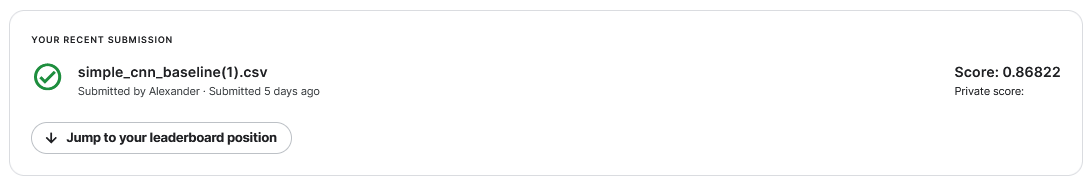

*Что ж, займёмся улучшениями.*

## 1. Аугментации

*Скор, конечно, до ужаса низкий, ключевая причина - лютейший дизбаланс классов: в одних больше тысячи картинок, в других - единицы.*

In [7]:
def get_count(labels):
    df = pd.DataFrame(labels, columns=['name'])
    df['count'] = 1
    return df.groupby('name').count().sort_values('count')

data = get_count(train_val_labels)

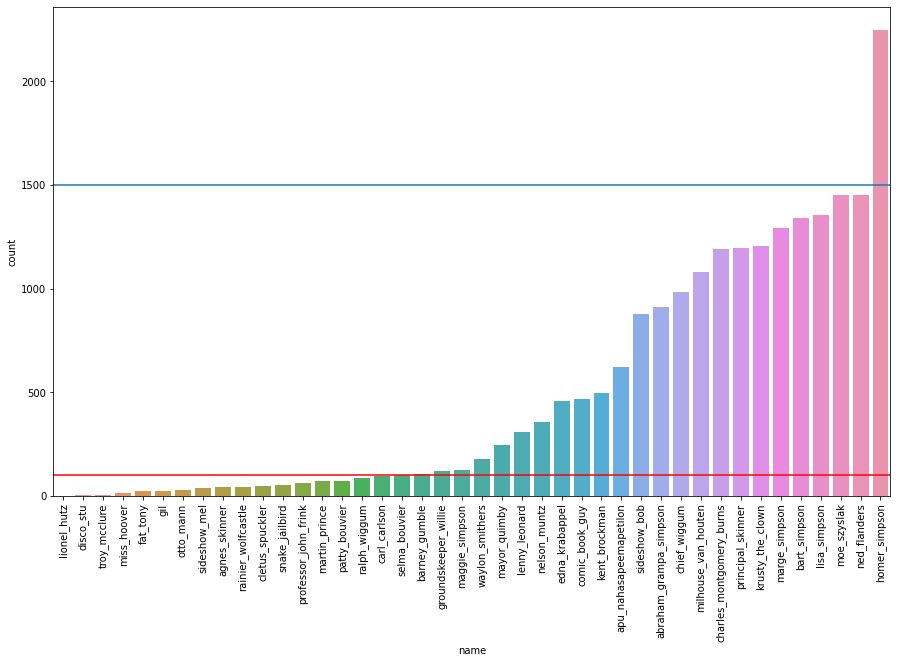

In [8]:
def show_data(data, min_level=True, max_level=True):
    plt.figure(figsize=(15, 9))
    sns.barplot(x=data.index, y=data['count'], orient='v').set_xticklabels(data.index, rotation=90)
    if max_level:
        plt.axhline(y=1500)
    if min_level:
        plt.axhline(y=100, color='red')
    plt.show()
    
show_data(data)

*Решать проблему будем в два этапа: для тех персонажей, чьих изображений в исходном датасете совсем мало, мы вручную добавим картинок из интернета; в остальных случаях применим случайные трансформации (кадрирование, отзеркаливание, поворот, искажение перспективы и т.д.)*

# 1. Дополнительный скрапинг данных из гугл картинок #
*Для этого был написан ещё один модуль, который автоматизирует поиск и загрузку картинок по запросу в гугле.*

In [ ]:
import socket
import ssl

socket.setdefaulttimeout(15)

def search(query: str, n_images: int, path: str, ijn: int):
    
    print("Scrapping images on query \"", query, "\"")
    
    path = path+str(query)+"/"
    os.makedirs(path)
    
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.5060.114 Safari/537.36"
    }

    params = {
        "q": query+" simpsons",              # search query
        "tbm": "isch",                # image results
        "hl": "en",                   # language of the search
        "gl": "us",                   # country where search comes from
        "ijn": ijn                    # page number
    }

    html = requests.get("https://www.google.com/search", params=params, headers=headers, timeout=30)
    soup = BeautifulSoup(html.text)

    """
    https://kodlogs.com/34776/json-decoder-jsondecodeerror-expecting-property-name-enclosed-in-double-quotes
    if you try to json.loads() without json.dumps() it will throw an error:
    "Expecting property name enclosed in double quotes"
    """

    google_images = []

    all_script_tags = soup.select("script")

    # # https://regex101.com/r/48UZhY/4
    matched_images_data = "".join(re.findall(r"AF_initDataCallback\(([^<]+)\);", str(all_script_tags)))

    matched_images_data_fix = json.dumps(matched_images_data)
    matched_images_data_json = json.loads(matched_images_data_fix)

    # https://regex101.com/r/VPz7f2/1
    matched_google_image_data = re.findall(r'\"b-GRID_STATE0\"(.*)sideChannel:\s?{}}', matched_images_data_json)

    # https://regex101.com/r/NnRg27/1
    matched_google_images_thumbnails = ", ".join(
        re.findall(r'\[\"(https\:\/\/encrypted-tbn0\.gstatic\.com\/images\?.*?)\",\d+,\d+\]',
                   str(matched_google_image_data))).split(", ")

    thumbnails = [
        bytes(bytes(thumbnail, "ascii").decode("unicode-escape"), "ascii").decode("unicode-escape") for thumbnail in matched_google_images_thumbnails
    ]

    # removing previously matched thumbnails for easier full resolution image matches.
    removed_matched_google_images_thumbnails = re.sub(
        r'\[\"(https\:\/\/encrypted-tbn0\.gstatic\.com\/images\?.*?)\",\d+,\d+\]', "", str(matched_google_image_data))

    # https://regex101.com/r/fXjfb1/4
    # https://stackoverflow.com/a/19821774/15164646
    matched_google_full_resolution_images = re.findall(r"(?:'|,),\[\"(https:|http.*?)\",\d+,\d+\]", removed_matched_google_images_thumbnails)

    full_res_images = [
        bytes(bytes(img, "ascii").decode("unicode-escape"), "ascii").decode("unicode-escape") for img in matched_google_full_resolution_images
    ]

    for index, (thumbnail, original) in enumerate(zip(thumbnails, full_res_images), start=1):

        if index>n_images:
            print("index:", index, "n_images:", n_images)
            break

        # Download original images
        print(f"Downloading {index} image...")

        opener=urllib.request.build_opener()
        opener.addheaders=[("User-Agent","Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.5060.114 Safari/537.36")]
        urllib.request.install_opener(opener)
        
        try:
            urllib.request.urlretrieve(original, path+f"/original_size_img_{index}.jpg")
        except urllib.error.URLError as err:
            print("HTTPError: ", err)
            pass
        except ConnectionResetError as err:
            print("ConnectionResetError: ", err)
            pass
        except socket.timeout as err:
            print("socker.timeout: ", err)
            pass
        except ssl.SSLError as err:
            print("SSLError: ", err)
            pass
# https://serpapi.com/blog/scrape-google-images-with-python/


*Для тех персонажей, у кого меньше 100 картинок, мы скачаем дополнительные из гугл картинок.*

In [ ]:
data['count'][data['count']<100]

name
lionel_hutz              3
disco_stu                8
troy_mcclure             8
miss_hoover             17
fat_tony                27
gil                     27
otto_mann               32
sideshow_mel            40
agnes_skinner           42
rainier_wolfcastle      45
cletus_spuckler         47
snake_jailbird          55
professor_john_frink    65
martin_prince           71
patty_bouvier           72
ralph_wiggum            89
carl_carlson            98
Name: count, dtype: int64

In [ ]:
%%time
for name, count in data['count'][data['count']<100].items():
    search(query=name, n_images=110-count, path="augmentations/", ijn=0)

*Подвязываем папку /augmentations к тренировочному датасету.*

In [9]:
# обновим списки файлов
AUG_DIR = Path("gdrive/MyDrive/Colab Notebooks/augmentations")

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')) + list(AUG_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

In [10]:
data = get_count(train_val_labels)

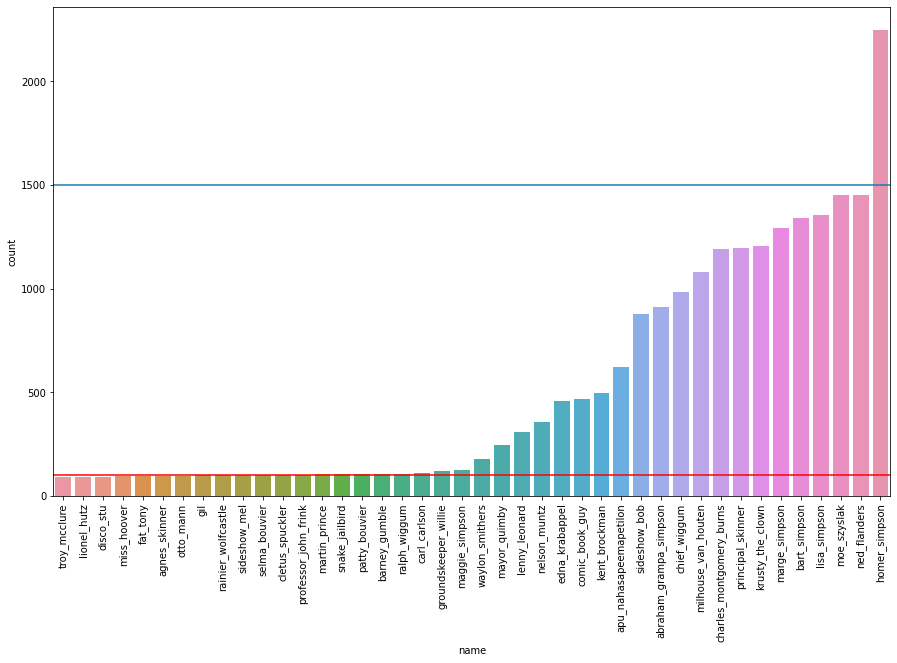

In [11]:
show_data(data)

*Отлично, теперь нет совсем бедных классов.*

**Далее мы реализуем непосредственно аугментацию - с помощью заранее прописанных трансформаций и RandomWeightedSampler-a.**

In [12]:
basic_transforms = [
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]

augmentations = [
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=(-25, 25)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Compose([
            transforms.Resize(size=300, max_size=301),
            transforms.CenterCrop(size=300),
            transforms.RandomCrop(250)
        ]),
    ])
]

train_transforms = transforms.Compose(augmentations + basic_transforms)
val_transforms = train_transforms
test_transforms = transforms.Compose(basic_transforms)

*Делаем свой класс датасета, чтобы включить в **\__getitem__** трансформации.*

In [13]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        if image.mode != "RGB":
            image = image.convert("RGB")
        return image
  
    def __getitem__(self, index):

        x = self.load_sample(self.files[index])
        
        if self.mode in ['train', 'val']:
            x = train_transforms(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
        else:
            x = test_transforms(x)
            return x
      

In [14]:
from sklearn.model_selection import train_test_split

# Разделим датасет на train и valid выборку
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

# Инициализируем датасеты
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [15]:
from collections import Counter
from torch.utils.data.sampler import WeightedRandomSampler

class_count = Counter(train_dataset.labels)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_dataset)):
    class_weight = class_weights[train_dataset.label_encoder.classes_[label]]
    sample_weights[i] = class_weight

N = max(class_count.values()) * len(class_count)  # fit to max
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

  0%|          | 33/16428 [00:32<5:06:23,  1.12s/it]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 16428/16428 [12:33<00:00, 21.80it/s] 


### Давайте посмотрим на наших героев внутри датасета.

In [23]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

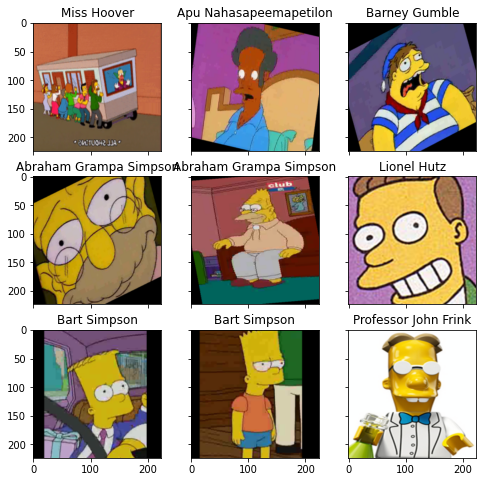

In [43]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# 2. Построение нейросети

*Baseline сеть состоит из пяти свёрточных слоёв с последующей активацией ReLU и макс-пулингом. В итоге из входа 3х224х224 мы получаем выход 96х5х5, пропускаем через линейный слой и получаем 42 логита по числу классов.*

*В качестве улучшений baseline-a мы:*
 - добавим пару полносвязных слоёв перед выходом, получив практически AlexNet;
 - увеличим число эпох с 5 до 10;
 - будем применять AMSGrad с встроенным в torch scheduler-ом;

In [44]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=2400, out_features=4096, bias=True),
            nn.ReLU(inplace=True)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True)
        )

        self.out = nn.Linear(4096, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)

        logits = self.out(x)
        return logits

In [45]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = torch.Tensor(labels)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step()          
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [46]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = torch.Tensor(labels)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [47]:
def train(train_loader, val_loader, model, epochs):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [48]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [49]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_f

*Запустим обучение сети:*

In [50]:
history = train(train_loader, val_loader, model=simple_cnn, epochs=10)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


loss 2.125080876322896


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:  10%|█         | 1/10 [13:24<2:00:43, 804.88s/it]


Epoch 001 train_loss: 2.1251     val_loss 1.5363 train_acc 0.4225 val_acc 0.5920
loss 0.5373938106368696


epoch:  20%|██        | 2/10 [22:21<1:26:17, 647.23s/it]


Epoch 002 train_loss: 0.5374     val_loss 1.3367 train_acc 0.8492 val_acc 0.6843
loss 0.2843638362944254


epoch:  30%|███       | 3/10 [31:27<1:10:06, 600.91s/it]


Epoch 003 train_loss: 0.2844     val_loss 1.2871 train_acc 0.9182 val_acc 0.7131
loss 0.20125131748684957


epoch:  40%|████      | 4/10 [40:33<57:55, 579.25s/it]


Epoch 004 train_loss: 0.2013     val_loss 1.2533 train_acc 0.9406 val_acc 0.7456


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eff89611ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eff89611ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

loss 0.1532116843200609


epoch:  50%|█████     | 5/10 [49:41<47:19, 567.89s/it]


Epoch 005 train_loss: 0.1532     val_loss 1.2532 train_acc 0.9561 val_acc 0.7701


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eff89611ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eff89611ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

loss 0.1252776798647339


epoch:  60%|██████    | 6/10 [58:42<37:15, 558.88s/it]


Epoch 006 train_loss: 0.1253     val_loss 1.3368 train_acc 0.9631 val_acc 0.7538


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eff89611ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eff89611ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

loss 0.10636429877294622


epoch:  70%|███████   | 7/10 [1:07:56<27:51, 557.11s/it]


Epoch 007 train_loss: 0.1064     val_loss 1.2007 train_acc 0.9684 val_acc 0.7878


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eff89611ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eff89611ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

loss 0.04864906356499441


epoch:  80%|████████  | 8/10 [1:17:10<18:32, 556.06s/it]


Epoch 008 train_loss: 0.0486     val_loss 1.1473 train_acc 0.9860 val_acc 0.8161


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eff89611ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eff89611ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

loss 0.03247149789750458


epoch:  90%|█████████ | 9/10 [1:27:09<09:29, 569.64s/it]


Epoch 009 train_loss: 0.0325     val_loss 1.1277 train_acc 0.9909 val_acc 0.8150


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eff89611ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eff89611ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

loss 0.028085484466255143


epoch: 100%|██████████| 10/10 [1:36:27<00:00, 578.80s/it]


Epoch 010 train_loss: 0.0281     val_loss 1.1607 train_acc 0.9920 val_acc 0.8216


*Построим кривые обучения:*

In [51]:
loss, acc, val_loss, val_acc = zip(*history)

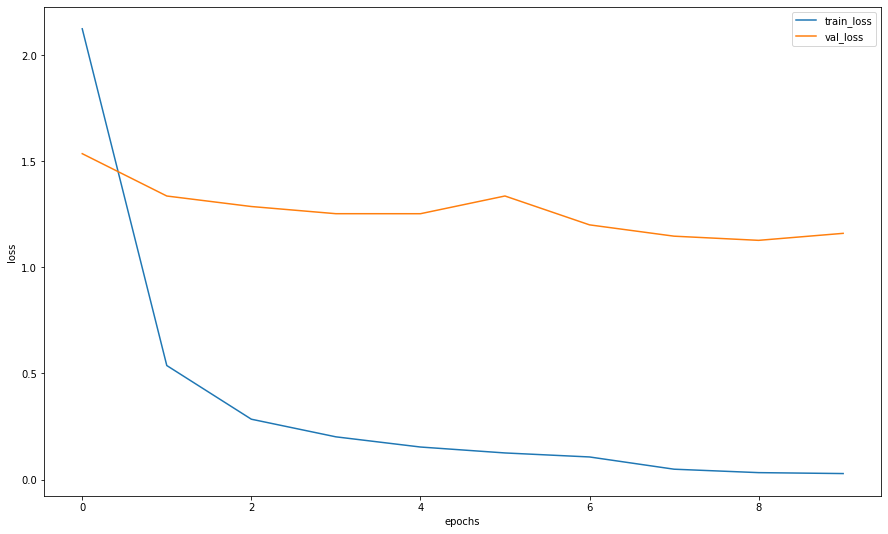

In [52]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

*Для сравнения: вот так выглядело обучение модели с аугментациями, но без полносвязных слоёв:*

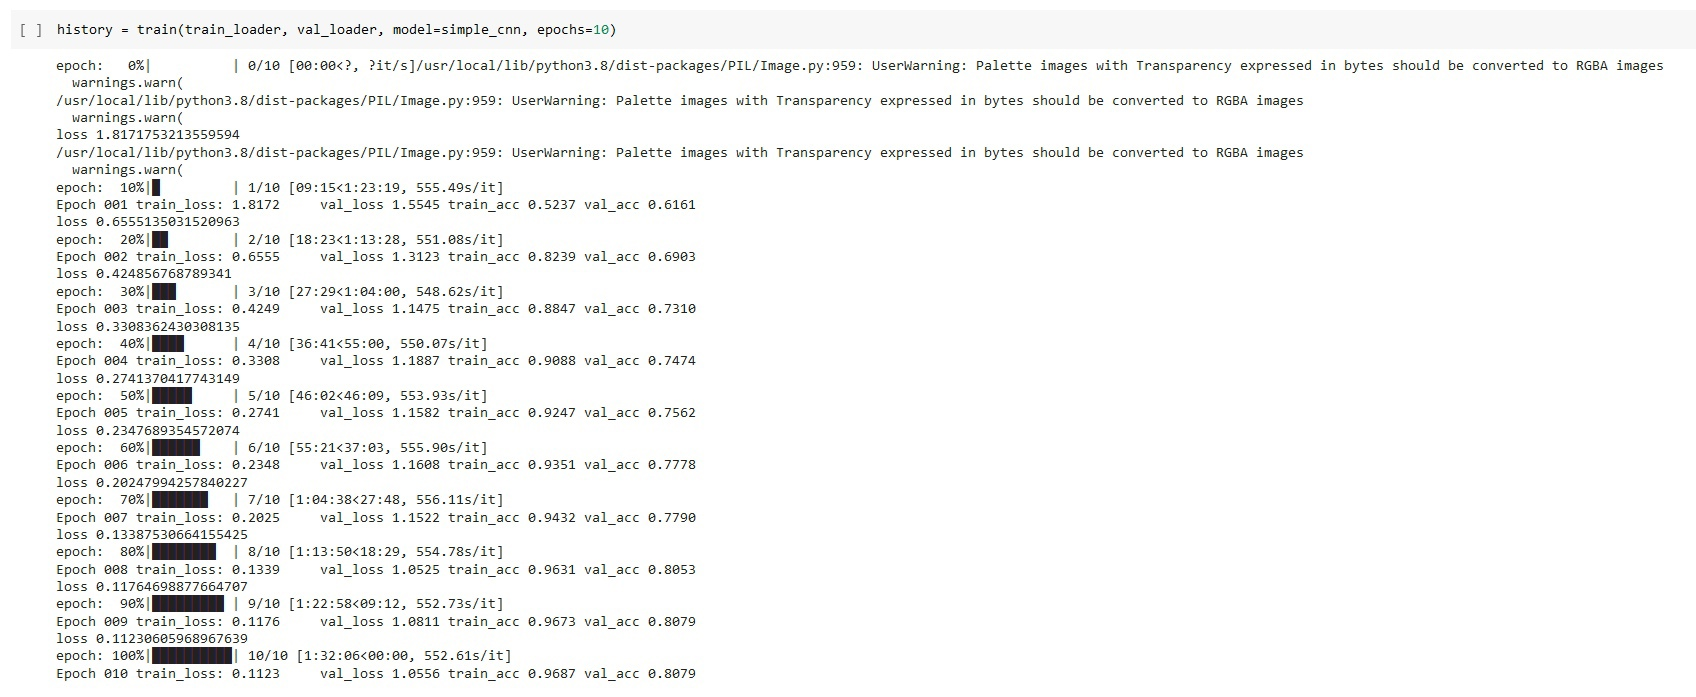

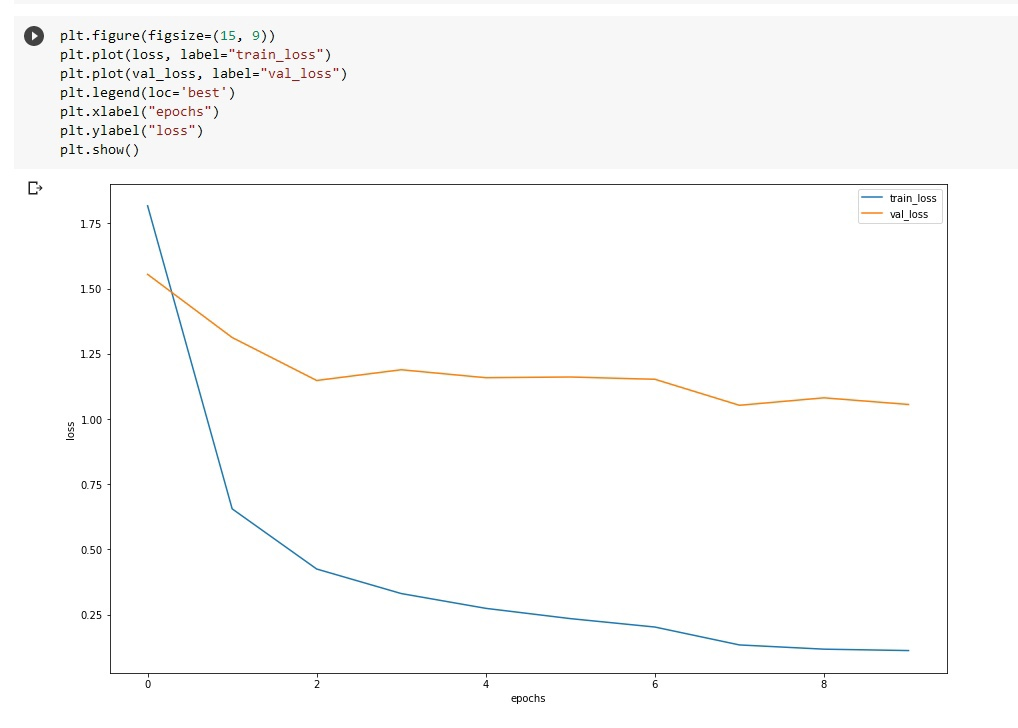

*Посмотрим скор модели на валидационном датасете (в соревновании на каггле необходимо оптимизировать f1-score, поэтому будем ориентироваться на него):*

In [59]:
idxs = list(map(int, np.random.uniform(0,1000, 200)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [60]:
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]

In [61]:
from sklearn.metrics import f1_score

f1_score(y_pred, actual_labels, average="micro")

0.685

### Submit на Kaggle

In [63]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [64]:
! ls gdrive/MyDrive/Colab\ Notebooks

 augmentations		     journey-springfield.zip
 augs.ipynb		    'simpsons_improved.ipynb"'
 baseline_aug.csv	     Untitled0.ipynb
 baseline_kaggle_score.png  'Копия блокнота "[hw]semantic_segmentation.ipynb"'
 journey-springfield


In [65]:
pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
}).to_csv("gdrive/MyDrive/Colab Notebooks/baseline_aug_2fc.csv", index=False)

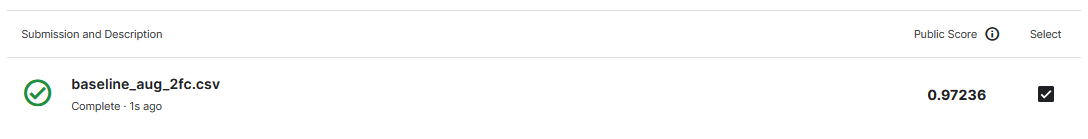

# Отдельное спасибо:
https://www.kaggle.com/code/marinalakeeva/data-augmentation

https://www.kaggle.com/code/vladislavzenin/baseline-batchnorm-dance-layers-aug-adamw

https://www.kaggle.com/code/wervlad/baseline-2fc-augmentations

https://www.kaggle.com/code/vladislavzenin/weightedrandomsampler